<a href="https://colab.research.google.com/github/cxbxmxcx/CalgaryDeepLearning/blob/master/DRL_SARSA_Discrete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [0]:
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[box2d] > /dev/null 2>&1

Requirement already up-to-date: setuptools in /usr/local/lib/python3.6/dist-packages (45.1.0)


In [0]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
from copy import deepcopy
%matplotlib inline
import math
import glob
import io
import base64
from tqdm import tqdm
from IPython.display import HTML

from IPython import display as ipythondisplay

In [0]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [0]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [0]:
from gym import envs
print(envs.registry.all())

dict_values([EnvSpec(Copy-v0), EnvSpec(RepeatCopy-v0), EnvSpec(ReversedAddition-v0), EnvSpec(ReversedAddition3-v0), EnvSpec(DuplicatedInput-v0), EnvSpec(Reverse-v0), EnvSpec(CartPole-v0), EnvSpec(CartPole-v1), EnvSpec(MountainCar-v0), EnvSpec(MountainCarContinuous-v0), EnvSpec(Pendulum-v0), EnvSpec(Acrobot-v1), EnvSpec(LunarLander-v2), EnvSpec(LunarLanderContinuous-v2), EnvSpec(BipedalWalker-v2), EnvSpec(BipedalWalkerHardcore-v2), EnvSpec(CarRacing-v0), EnvSpec(Blackjack-v0), EnvSpec(KellyCoinflip-v0), EnvSpec(KellyCoinflipGeneralized-v0), EnvSpec(FrozenLake-v0), EnvSpec(FrozenLake8x8-v0), EnvSpec(CliffWalking-v0), EnvSpec(NChain-v0), EnvSpec(Roulette-v0), EnvSpec(Taxi-v3), EnvSpec(GuessingGame-v0), EnvSpec(HotterColder-v0), EnvSpec(Reacher-v2), EnvSpec(Pusher-v2), EnvSpec(Thrower-v2), EnvSpec(Striker-v2), EnvSpec(InvertedPendulum-v2), EnvSpec(InvertedDoublePendulum-v2), EnvSpec(HalfCheetah-v2), EnvSpec(HalfCheetah-v3), EnvSpec(Hopper-v2), EnvSpec(Hopper-v3), EnvSpec(Swimmer-v2), EnvSp

In [0]:
env = wrap_env(gym.make('CartPole-v0'))
Q_table = np.zeros((20,20,20,20,3))
alpha=0.3
buckets=[20, 20, 20, 20]
gamma=0.99
rewards=[]
episodes = 3000

In [0]:
#check out the pacman action space!
print(env.action_space)

Discrete(2)


Core functions

In [0]:
def to_discrete_states(observation):
	interval=[0 for i in range(len(observation))]
	max_range=[2.4,999999, 41.8,999999]	

	for i in range(len(observation)):
		data = observation[i]
		inter = int(math.floor((data + max_range[i])/(2*max_range[i]/buckets[i])))
		if inter>=buckets[i]:
			interval[i]=buckets[i]-1
		elif inter<0:
			interval[i]=0
		else:
			interval[i]=inter
	return interval

def expect_epsilon(t):
    return min(0.015, 1.0 - math.log10((t+1)/220.))

def expect_alpha(t):
    return min(0.1, 1.0 - math.log10((t+1)/125.))

def get_action(observation,t): 
    if np.random.random()<max(0.001, expect_epsilon(t)):
        return env.action_space.sample()
    interval = to_discrete_states(observation)
    return np.argmax(np.array(Q_table[tuple(interval)]))

def update_SARSA(observation,reward,action,ini_obs,next_action,t):	
	interval = to_discrete_states(observation)
	Q_next = Q_table[tuple(interval)][next_action]
	ini_interval = to_discrete_states(ini_obs)
	Q_table[tuple(ini_interval)][action]+=max(0.4, expect_alpha(t))*(reward + gamma*(Q_next) - Q_table[tuple(ini_interval)][action])


Training

100%|██████████| 3000/3000 [01:26<00:00, 34.64it/s]


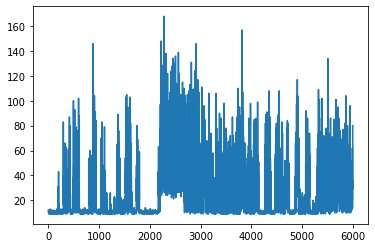

In [0]:
for episode in tqdm(range(episodes)):
    observation = env.reset() 
    t=0
    done=False
    while (done==False):
        env.render()        
        action = get_action(observation,episode)
        obs_next, reward, done, info = env.step(action)
        next_action = get_action(obs_next,episode)
        update_SARSA(obs_next,reward,action,observation,next_action,episode)	
        observation=obs_next
        action = next_action
        t+=1
    rewards.append(t+1)			

plt.plot(rewards)
plt.show()
show_video()

Playit